In [48]:
import numpy as np
from sklearn.mixture import GaussianMixture
import wave
import math
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile
import python_speech_features as psf
import vad_utils as vad
import evaluate as eva

"""
已知音频文件采样率均为16kHz
取帧长度32ms : frame_length = 512
取帧移8ms : step = 128
"""

# 路径
dev_wav_path = "../vad/wavs/dev"
train_wav_path = "../vad/wavs/train"
label_path = "../vad/data"

# 读label文件
dev_label_data = vad.read_label_from_file(label_path + "/dev_label.txt")
train_label_data = vad.read_label_from_file(label_path + "/train_label.txt")
print("Read label success")

# 读取文件夹
dev_files = os.listdir(dev_wav_path)
train_files = os.listdir(train_wav_path)
print("Read files success")


Read label success
Read files success


In [49]:
# total_frames = 0

voice_features = []
nonvoice_features = []
print("List initialize success")

for file in train_files:
    # 读取当前wav的label
    current_label_data = train_label_data[file[0:-4]]
    # 读取当前wav文件
    sample_rate, wav_data = wavfile.read(train_wav_path + "/" + file)

    print("Processing " + train_wav_path + "/" + file)

    wav_vector = psf.base.mfcc(wav_data, 16000, 0.032, 0.008)

    # 计算帧数
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)

    # total_frames += num_of_steps

    # print(num_of_steps)
    # print(len(wav_vector))

    # 时间轴
    time = np.zeros(num_of_steps)
    for i in range(num_of_steps):
        time[i] = (i * 128 + 256) / 16000
    
    # 补零
    current_label_data = train_label_data[file[0:-4]]
    current_label_data = list(current_label_data) + list(
        np.zeros(len(time) - len(current_label_data))
    )

    for i in range(num_of_steps):
        if current_label_data[i] == 1:
            # 标记为语音片段的帧
            voice_features.append(wav_vector[i])
        else:
            # 标记为非语音片段的帧
            nonvoice_features.append(wav_vector[i])
    
    # print(wav_vector)
    print(np.array(wav_vector).shape)
    # break


List initialize success
(1738, 13)
(2018, 13)
(1704, 13)
(1894, 13)
(1864, 13)
(1839, 13)
(1967, 13)
(1887, 13)
(1811, 13)
(1930, 13)
(1601, 13)
(1937, 13)
(2224, 13)
(1627, 13)
(1797, 13)
(1670, 13)
(1993, 13)
(1927, 13)
(1943, 13)
(1906, 13)
(1367, 13)
(1776, 13)
(1397, 13)
(1981, 13)
(2055, 13)
(1845, 13)
(1642, 13)
(2079, 13)
(1486, 13)
(1692, 13)
(2009, 13)
(1852, 13)
(1874, 13)
(1534, 13)
(2049, 13)
(2006, 13)
(1894, 13)
(1912, 13)
(1762, 13)
(1867, 13)
(1554, 13)
(1585, 13)
(1707, 13)
(1866, 13)
(1985, 13)
(1412, 13)
(1688, 13)
(1796, 13)
(1764, 13)
(1881, 13)
(1850, 13)
(1829, 13)
(1792, 13)
(1394, 13)
(1532, 13)
(1428, 13)
(2013, 13)
(1576, 13)
(1876, 13)
(1300, 13)
(1942, 13)
(1629, 13)
(1599, 13)
(1993, 13)
(1906, 13)
(1918, 13)
(1911, 13)
(1871, 13)
(1612, 13)
(1638, 13)
(1827, 13)
(1756, 13)
(1887, 13)
(1767, 13)
(1765, 13)
(1934, 13)
(1309, 13)
(2062, 13)
(2004, 13)
(1957, 13)
(1850, 13)
(1929, 13)
(1876, 13)
(1958, 13)
(1746, 13)
(1861, 13)
(1785, 13)
(1289, 13)
(1746, 1

In [51]:
# 语音片段
print(len(voice_features))
# voice_features = np.vstack((voice_features, voice_vector))
# 非语音片段
print(len(nonvoice_features))
# nonvoice_features = np.vstack((voice_features, nonvoice_vector))



5168743
1181335


In [52]:
print("\nTraining voice GMM...\n")
voice_gmm = GaussianMixture(n_components=26)
voice_gmm.fit(voice_features)
print("Voice GMM converged: ")
print(voice_gmm.converged_)

print("\nTraining voice GMM...\n")
nonvoice_gmm = GaussianMixture(n_components=26)
nonvoice_gmm.fit(nonvoice_features)
print("Nonvoice GMM converged: ")
print(nonvoice_gmm.converged_)


Training voice GMM...

Voice GMM converged: 
True

Training voice GMM...

Nonvoice GMM converged: 
True


In [14]:
def get_acc(prediction, actual):
    """
    input:
        prediction 预测list eg.[0,0,1,0,...,1,0]
        actual 从实际label文件中读取的list
    return:
        acc accuracy
    """
    total_frame = len(actual)
    correct_frame = 0

    for i in range(total_frame):
        if prediction[i] == actual[i]:
            correct_frame += 1
    acc = correct_frame / total_frame

    return acc

In [76]:
"""
    /dev
    开发集
    所有不随循环消亡的变量均带dev_前缀
"""

# 创建输出文件
dev_output = open("dev_output.txt", "w")

# 用于计算AUC、EER、ROC等指标的变量，不随循环消亡
dev_reserve_for_cal = []
dev_label_for_cal = []

# 读取开发集label，返回dict
dev_label_data = vad.read_label_from_file(label_path + "/dev_label.txt")

for file in dev_files:
    sample_rate, wav_data = wavfile.read(dev_wav_path + "/" + file)

    print("Processing " + dev_wav_path + "/" + file)

    vectors = psf.base.mfcc(wav_data, sample_rate, 0.032, 0.008)

    # # 计算两个模型下的predict
    # voice_predict = np.array(voice_gmm.predict(vectors))
    # non_predict = np.array(nonvoice_gmm.predict(vectors))

    # 计算两个模型下的scores
    voice_score_samples = np.array(voice_gmm.score_samples(vectors))
    non_score_samples = np.array(nonvoice_gmm.score_samples(vectors))

    # print(voice_score_samples)
    # print(non_score_samples)
    # print(len(voice_score))
    # print(len(non_score))

    # 计算帧数，帧数、两个predict的长度应都相同
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)
    # print(num_of_steps)

    # 时间轴
    time = np.zeros(num_of_steps)
    for i in range(num_of_steps):
        time[i] = (i * 128 + 256) / 16000

    # 补零
    current_label_data = dev_label_data[file[0:-4]]
    current_label_data = list(current_label_data) + list(
        np.zeros(len(time) - len(current_label_data))
    )
    # print(len(current_label_data))

    # 保存label
    for i in range(len(current_label_data)):
        dev_label_for_cal.append(current_label_data[i])
    # print(len(dev_label_for_cal))
    
    # 定义并初始化保存单个wav文件中各帧prediction的list
    result = []

    # 取大
    for i in range(len(voice_score_samples)):
        if voice_score_samples[i] >= non_score_samples[i]:
            result.append(1)
            dev_reserve_for_cal.append(1)
        else:
            result.append(0)
            dev_reserve_for_cal.append(0)

    dev_label = []
    dev_label = vad.prediction_to_vad_label(result)

    dev_output.write(file[0:-4] + " " + dev_label + "\n")

dev_output.close()
print("\nComplete!\nResult file generated as dev.txt\n")


Processing ../vad/wavs/dev/1031-133220-0062.wav
Processing ../vad/wavs/dev/1031-133220-0091.wav
Processing ../vad/wavs/dev/1051-133881-0021.wav
Processing ../vad/wavs/dev/107-22885-0023.wav
Processing ../vad/wavs/dev/1084-145077-0022.wav
Processing ../vad/wavs/dev/1085-169444-0008.wav
Processing ../vad/wavs/dev/1085-169444-0040.wav
Processing ../vad/wavs/dev/1092-134562-0029.wav
Processing ../vad/wavs/dev/1097-136955-0031.wav
Processing ../vad/wavs/dev/111-126277-0016.wav
Processing ../vad/wavs/dev/1112-128138-0027.wav
Processing ../vad/wavs/dev/1124-134775-0023.wav
Processing ../vad/wavs/dev/1124-134775-0053.wav
Processing ../vad/wavs/dev/1124-134775-0085.wav
Processing ../vad/wavs/dev/1152-126549-0021.wav
Processing ../vad/wavs/dev/1152-126549-0051.wav
Processing ../vad/wavs/dev/1154-129975-0015.wav
Processing ../vad/wavs/dev/1154-129976-0019.wav
Processing ../vad/wavs/dev/119-129515-0001.wav
Processing ../vad/wavs/dev/1212-14653-0012.wav
Processing ../vad/wavs/dev/123-26848-0010.wav


Calculating AUC, EER, TPR, FPR, Threshold of dev dataset...

AUC =  0.9412815913493469
EER =  0.07168652112768321
TPR =  [0.         0.92831348 1.        ]
(3,)
FPR =  [0.        0.0457503 1.       ]
(3,)
ACC =  0.9330722640646232


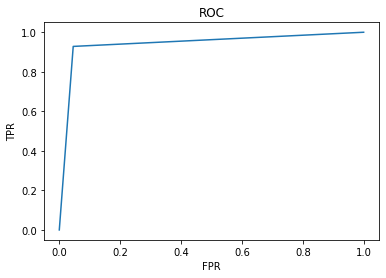

In [82]:
print("\nCalculating AUC, EER, TPR, FPR, Threshold of dev dataset...\n")
auc, eer, tpr, fpr, thres = eva.get_metrics(dev_reserve_for_cal, dev_label_for_cal)
print("AUC = ", auc)
print("EER = ", eer)
print("TPR = ", tpr)
print(tpr.shape)
print("FPR = ", fpr)
print(fpr.shape)
# print("Threshold = ", thres)

dev_acc = get_acc(dev_reserve_for_cal, dev_label_for_cal)
print("ACC = ", dev_acc)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.savefig("dev_ROC.png")
plt.show()

In [78]:
"""
    /train
    训练集
    所有不随循环消亡的变量均带train_前缀
"""

# 创建输出文件
train_output = open("train_output.txt", "w")

# 用于计算AUC、EER、ROC等指标的变量，不随循环消亡
train_reserve_for_cal = []
train_label_for_cal = []

# 读取开发集label，返回dict
train_label_data = vad.read_label_from_file(label_path + "/train_label.txt")

for file in train_files:
    sample_rate, wav_data = wavfile.read(train_wav_path + "/" + file)

    print("Processing " + train_wav_path + "/" + file)

    vectors = psf.base.mfcc(wav_data, sample_rate, 0.032, 0.008)

    # # 计算两个模型下的predict
    # voice_predict = np.array(voice_gmm.predict(vectors))
    # non_predict = np.array(nonvoice_gmm.predict(vectors))

    # 计算两个模型下的scores
    voice_score_samples = np.array(voice_gmm.score_samples(vectors))
    non_score_samples = np.array(nonvoice_gmm.score_samples(vectors))

    # print(voice_score_samples)
    # print(non_score_samples)
    # print(len(voice_score))
    # print(len(non_score))

    # 计算帧数，帧数、两个predict的长度应都相同
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)
    # print(num_of_steps)

    # 时间轴
    time = np.zeros(num_of_steps)
    for i in range(num_of_steps):
        time[i] = (i * 128 + 256) / 16000

    # 补零
    current_label_data = train_label_data[file[0:-4]]
    current_label_data = list(current_label_data) + list(
        np.zeros(len(time) - len(current_label_data))
    )
    # print(len(current_label_data))

    # 保存label
    for i in range(len(current_label_data)):
        train_label_for_cal.append(current_label_data[i])
    # print(len(train_label_for_cal))
    
    # 定义并初始化保存单个wav文件中各帧prediction的list
    result = []

    # 取大
    for i in range(len(voice_score_samples)):
        if voice_score_samples[i] >= non_score_samples[i]:
            result.append(1)
            train_reserve_for_cal.append(1)
        else:
            result.append(0)
            train_reserve_for_cal.append(0)

    train_label = []
    train_label = vad.prediction_to_vad_label(result)

    train_output.write(file[0:-4] + " " + train_label + "\n")

train_output.close()
print("\nComplete!\nResult file generated as train.txt\n")


Processing ../vad/wavs/train/100-122655-0035.wav
Processing ../vad/wavs/train/1001-134707-0047.wav
Processing ../vad/wavs/train/1001-134708-0032.wav
Processing ../vad/wavs/train/1006-135212-0043.wav
Processing ../vad/wavs/train/1006-135212-0101.wav
Processing ../vad/wavs/train/101-126859-0017.wav
Processing ../vad/wavs/train/101-126860-0032.wav
Processing ../vad/wavs/train/1012-133424-0068.wav
Processing ../vad/wavs/train/1018-133447-0021.wav
Processing ../vad/wavs/train/1018-135221-0009.wav
Processing ../vad/wavs/train/102-129232-0014.wav
Processing ../vad/wavs/train/102-129232-0086.wav
Processing ../vad/wavs/train/1025-75365-0009.wav
Processing ../vad/wavs/train/1025-92820-0009.wav
Processing ../vad/wavs/train/1027-125147-0002.wav
Processing ../vad/wavs/train/1028-133393-0010.wav
Processing ../vad/wavs/train/1028-133395-0007.wav
Processing ../vad/wavs/train/103-1240-0008.wav
Processing ../vad/wavs/train/103-1241-0002.wav
Processing ../vad/wavs/train/1034-121119-0019.wav
Processing ..


Calculating AUC, EER, TPR, FPR, Threshold of train dataset...

AUC =  0.9426234134743758
EER =  0.07334916826005859
TPR =  [0.         0.92665083 1.        ]
(3,)
FPR =  [0.       0.041404 1.      ]
(3,)
ACC =  0.9325937413682163


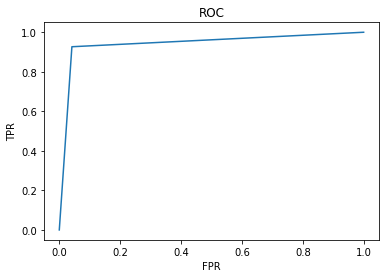

In [83]:
print("\nCalculating AUC, EER, TPR, FPR, Threshold of train dataset...\n")
auc, eer, tpr, fpr, thres = eva.get_metrics(train_reserve_for_cal, train_label_for_cal)
print("AUC = ", auc)
print("EER = ", eer)
print("TPR = ", tpr)
print(tpr.shape)
print("FPR = ", fpr)
print(fpr.shape)
# print("Threshold = ", thres)

train_acc = get_acc(train_reserve_for_cal, train_label_for_cal)
print("ACC = ", train_acc)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.savefig("train_ROC.png")
plt.show()

In [81]:
"""
    test/
    测试集
    所有不随循环消亡的变量均带test_前缀
"""

# 创建输出文件
test_output = open("test_output.txt", "w")

# 定义测试集语音路径
test_wav_path = "../vad/wavs/test"

# 读取测试集文件夹
test_files = os.listdir(test_wav_path)

# 用于计算AUC、EER、ROC等指标的变量，不随循环消亡
test_reserve_for_cal = []
test_label_for_cal = []

for file in test_files:
    # 读取语音
    sample_rate, wav_data = wavfile.read(test_wav_path + "/" + file)
    print("Processing " + test_wav_path + "/" + file)

    # MFCC
    vectors = psf.base.mfcc(wav_data, sample_rate, 0.032, 0.008)

    # 计算帧数
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)

    # 计算两个模型下的scores
    voice_score_samples = np.array(voice_gmm.score_samples(vectors))
    non_score_samples = np.array(nonvoice_gmm.score_samples(vectors))
    
    # 定义并初始化保存单个wav文件中各帧prediction的list
    result = []

    # 取大
    for i in range(len(voice_score_samples)):
        if voice_score_samples[i] >= non_score_samples[i]:
            result.append(1)
            test_reserve_for_cal.append(1)
        else:
            result.append(0)
            test_reserve_for_cal.append(0)

    # test_label是保存单个wav文件VAD label的list
    test_label = []
    test_label = vad.prediction_to_vad_label(result)
    test_output.write(file[0:-4] + " " + test_label + "\n")

test_output.close()
print("\nComplete!\nResult file generated as test_output.txt\n")


Processing ../vad/wavs/test/104-132091-0020.wav
Processing ../vad/wavs/test/104-132091-0028.wav
Processing ../vad/wavs/test/104-132091-0041.wav
Processing ../vad/wavs/test/104-132091-0050.wav
Processing ../vad/wavs/test/104-132091-0061.wav
Processing ../vad/wavs/test/128-134883-0005.wav
Processing ../vad/wavs/test/128-134883-0014.wav
Processing ../vad/wavs/test/128-134883-0025.wav
Processing ../vad/wavs/test/128-134883-0034.wav
Processing ../vad/wavs/test/128-134883-0045.wav
Processing ../vad/wavs/test/1280-135136-0008.wav
Processing ../vad/wavs/test/1280-135136-0015.wav
Processing ../vad/wavs/test/1280-135136-0023.wav
Processing ../vad/wavs/test/1280-135136-0032.wav
Processing ../vad/wavs/test/1280-135136-0041.wav
Processing ../vad/wavs/test/1280-135136-0051.wav
Processing ../vad/wavs/test/1280-135136-0059.wav
Processing ../vad/wavs/test/1280-135136-0066.wav
Processing ../vad/wavs/test/1289-288044-0005.wav
Processing ../vad/wavs/test/1289-288044-0012.wav
Processing ../vad/wavs/test/12

In [ ]:
print("\nCalculating AUC, EER, TPR, FPR, Threshold of test dataset...\n")
auc, eer, tpr, fpr, thres = eva.get_metrics(dev_reserve_for_cal, dev_label_data)
print("AUC = ", auc)
print("EER = ", eer)
print("TPR = ", tpr)
print("FPR = ", fpr)
print("Threshold = ", thres)